### This code is an initial attempt at a nowcasting model
* It is an attempt to brute force through the nowcasting framework
* What I ended up with was closest to the [MIDAS framework](https://en.wikipedia.org/wiki/Mixed-data_sampling)
* **Next steps:**
* Create a test version using a proper MIDAS model: https://github.com/sapphire921/midas_pro 
* Create a state space nowcasting model 

In [26]:
import pandas as pd
import numpy as np
import xgboost as xgb
import config
from fredapi import Fred
vars = pd.read_csv('vars.csv')

print(vars.head())
LF_list = list()
P_list = list()
all_list = list()
trans_in = {}

#extract all of the relevant info into lists 
for index, row in vars.iterrows():
    fred_code=row['code']
    trans_in[fred_code] = row['trans']
    all_list.append(fred_code)
    if row['block'] == 'LM':
        LF_list.append(fred_code)
    elif row['block'] == 'PRICES':
        P_list.append(fred_code)
        
glob_list = all_list.copy()
glob_list.remove('GDPC1')

#Specify factor and number of components
# factors = {'Labor':LF_list,'Prices':P_list,'Global':glob_list}
factors = {'Labor':LF_list,'Prices':P_list}

#Specify number of PCs for each 
factor_counts = {'Labor':1,'Prices':1}

          code                                               name block trans
0  FRBKCLMCILA  KC Fed Labor Market Conditions Index, Level of...    LM   NaN
1         ICSA                                     Initial Claims    LM   apc
2         CCSA                                  Continued Claims     LM   apc
3       PAYEMS                       All Employees, Total Nonfarm    LM   apc
4      CIVPART                    Labor Force Participation Rate     LM   apc


In [27]:
#This is my custom function for fred downloads
# User will need a FRED API key, can sign up for one here https://fred.stlouisfed.org/docs/api/api_key.html
# replace with your own API key: fred = Fred(api_key='YOUR KEY HERE')
fred = Fred(api_key=config.api_key)

"""
DEFINE: fredget() => a function to retrieve series, store info, and plot data 
-----------------------INPUTS -------------------------------
varlist: a list of FRED codes ex. FRED_list = ['GDP','SP500']
start_date & end_date: set the chosen sample ex. start_d ='1990-01-01'
plots (Optional): True/False => set whether to show a preview of the data during collection
freq (Optional): default is not to synchronize frequencies: choose 'm','q','a' if aggregating
name_map (Optional):dict containing remapped variable names for plot default titles
------------------------OUTPUTS -----------------------------
df_collect: the compiled data df with date set as index
info_store: DF containing series info (units, titles, notes, etc.)
"""

def fredget(varlist, start_date, end_date, plots=True,freq="",name_map = dict(),trans_dict=dict()):
    df_collect = pd.DataFrame()
    
    shift_dict = {'W':52,'M':12,'Q':4}
    
    for var in varlist:
        df_add = fred.get_series(var, observation_start = start_date, observation_end=end_date, frequency =freq).to_frame(name = var)
        info_add = fred.get_series_info(var).to_frame(name = var)
        print(var)
       
        #If user changes the freq
        if freq != "":
            info_add.loc['cur_freq', var] = freq
         
        if var in trans_dict:   
            if trans_dict[var] == 'apc':
                freq_var = info_add.loc['frequency_short', var] 
                df_add[var] = df_add[var].pct_change(shift_dict[freq_var])
                info_add.loc['units', var] ='Annual % Change'
                info_add.loc['units_short', var] ='12m %'
            
        if var in name_map:
            info_add.loc['user_title', var] = name_map[var]
        else:
            info_add.loc['user_title', var] = info_add.loc['title', var]
                    
        if plots == True:
            df_add.plot(y=var, use_index=True, kind='line', title = info_add.loc['user_title', var], ylabel = info_add.loc['units', var] )
            
        if df_collect.empty == True:
            df_collect = df_add
            info_store = info_add
        else:
            df_collect = pd.merge(df_collect, df_add, left_index=True, right_index=True, how='outer')
            info_store = pd.merge(info_store, info_add, left_index=True, right_index=True, how='left')
            
    df_collect.sort_index()
    return df_collect, info_store

FRBKCLMCILA
ICSA
CCSA
PAYEMS
CIVPART
UNRATE
PCEPI
PCEPILFE
CPIAUCSL
MICH
GDPC1


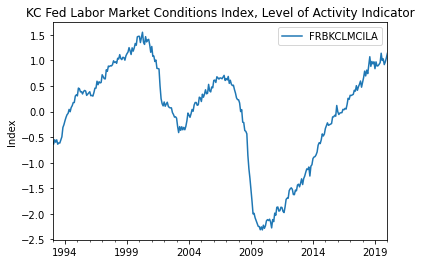

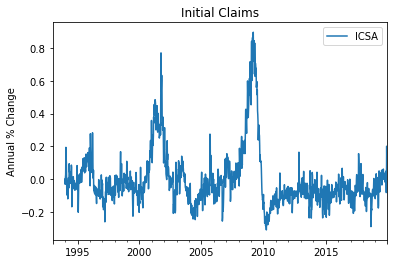

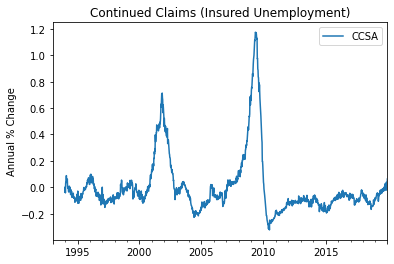

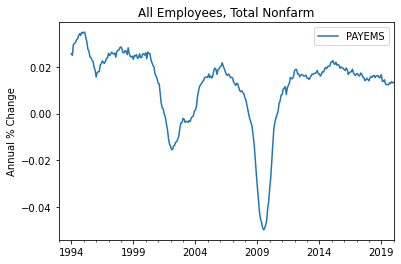

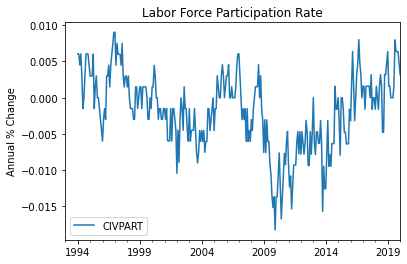

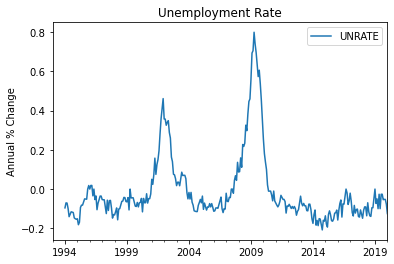

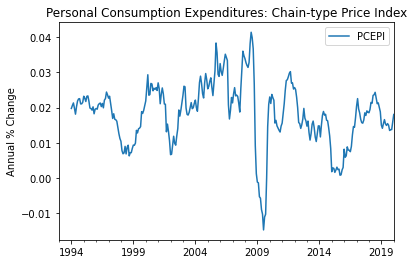

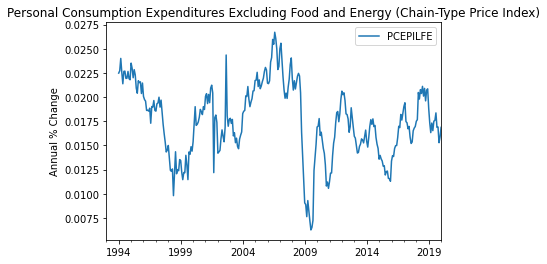

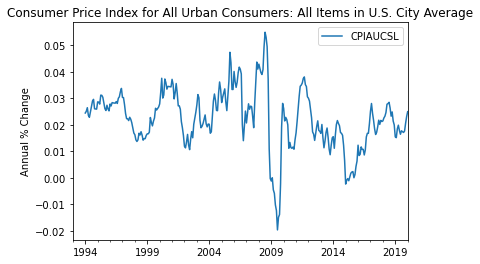

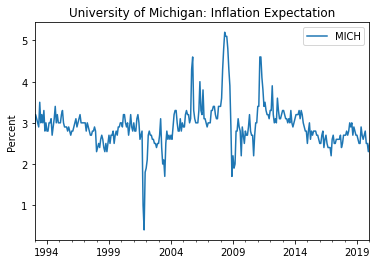

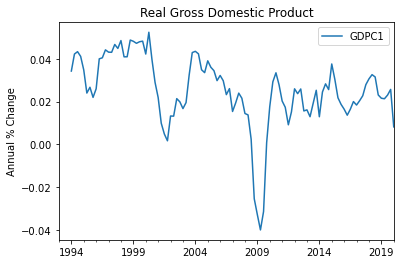

In [28]:

#Collect the data
s_d ='1993-01-01'
e_d='2020-01-01'
df_raw, dfinfo_raw = fredget(all_list, s_d, e_d, plots=True,trans_dict=trans_in)


[0.71612934] is explained by the Labor PC
[0.99884036] is explained by the Prices PC


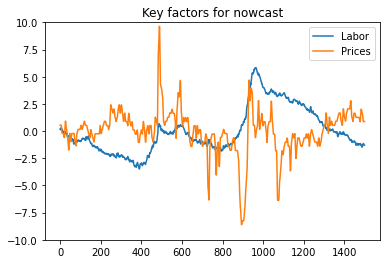

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px
from scipy import signal
import statsmodels.api as sm
from matplotlib import pyplot as plt

#Calculate the factors 

df = df_raw
df_orig = df_raw
#Need to come up with a way better method to interpolate the missing data, this was just a rough test 
df_interp = df.interpolate(method='polynomial', order=1)
# df_interp= df.fillna(method="bfill")
df_interp = df_interp.loc['1994-1-1':'2018-1-1']

factor_list = list()
#Use PCE to create the factors
for factor in factors:
    varlist = factors[factor]
    comp_count = factor_counts[factor]
    df_PCA = df_interp[varlist]
    x = StandardScaler().fit_transform(signal.detrend(df_PCA))
    pca = PCA(n_components=comp_count)
    df_PC = pca.fit_transform(x)
    print(f'{pca.explained_variance_ratio_} is explained by the {factor} PC')
    plt.plot(df_PC[:,0],label=factor)
    plt.title('Key factors for nowcast')
    plt.legend()
    plt.ylim((-10,10))
    df_add = pd.DataFrame(df_PC[:,0], columns = [factor], index = df_interp.index)
    df_interp = pd.concat([df_interp, df_add], axis=1) 
    factor_list.append(factor)
    


['Labor_L_1', 'Labor_L_8', 'Labor_L_13', 'Labor_L_26', 'Labor_L_39', 'Labor_L_52', 'Prices_L_1', 'Prices_L_8', 'Prices_L_13', 'Prices_L_26', 'Prices_L_39', 'Prices_L_52', 'gdp_lag1', 'gdp_lag2', 'gdp_lag3']


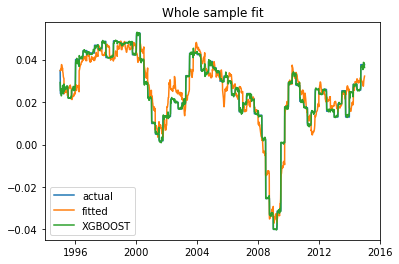

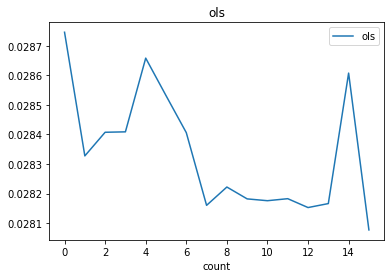

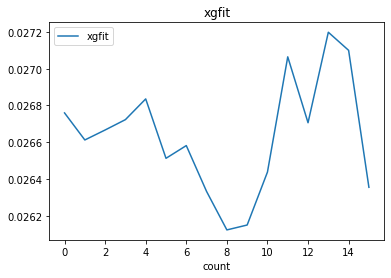

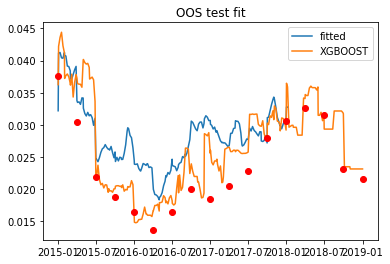

In [33]:
import math 
reglist = list()

#Join up the estimated factors with the initial data 
df_factors = df_interp[factor_list]
df_reg = df_raw.merge(df_factors,left_index=True,right_index=True, how='left')

#Create a bunch of lagged predictors in the PCs
lag_set = (1,8,13,26,39,52)
for f in factor_list:
    for i in lag_set:
        varname = f'{f}_L_{i}'
        reglist.append(varname)
        df_reg[varname] = df_reg[f].shift(i) 

#Determine the number of weeks away each observation is from the GDP release
df_reg['count'] = 0
idx = 0
for index, row in df_reg.iterrows():
    df_reg.loc[index,'count'] = idx
    idx+=1
    if not math.isnan(row['GDPC1']):
        idx = 0 
        
#Make an copy before backfilling GDP
df_reg['GDPC1_orig_freq']= df_reg['GDPC1']

laggdp = {0:0,1:15,2:30,3:45}

for lag_order in laggdp:
    lagname =f'gdp_lag{lag_order}'
    df_reg[lagname] = df_reg['GDPC1'].shift(laggdp[lag_order]) 
    df_reg[lagname]= df_reg[lagname].fillna(method="bfill")
    if lag_order != 0:
        reglist.append(f'gdp_lag{lag_order}')


print(reglist)
#Define sample 
df_model = df_reg.loc['1995-1-1':'2015-1-1']
x = df_model[reglist]
y = df_model['gdp_lag0']
x = sm.add_constant(x)

#Get fitted OLS Values
model = sm.OLS(y, x).fit()
fitted = model.fittedvalues

'''XGBOOST BEGINS HERE'''
#not yet tuned
regressor = xgb.XGBRegressor(
    n_estimators=100,
    reg_lambda=1,
    gamma=0,
    max_depth=4
)

#Compute XGB fit
regressor.fit(x, y)
xgpred = regressor.predict(x)
xg_df = pd.DataFrame(xgpred, columns = ['xgfit'], index = df_model.index)

#Plot the in-sample fit 
plt.plot(y,label="actual")
plt.plot(fitted,label="fitted")
plt.plot(xg_df['xgfit'],label="XGBOOST")
plt.legend()
plt.title('Whole sample fit')

#Set up a test time period 
df_test = df_reg.loc['2015-1-1':'2019-1-1']
y_test = df_test['gdp_lag0']
x_test = df_test[reglist]
x_test = sm.add_constant(x_test)
test_fit = model.predict(x_test)
ols_df = pd.DataFrame(test_fit, columns = ['ols'], index = df_test.index)
xgpred_test = regressor.predict(x_test)
xg_df_test = pd.DataFrame(xgpred_test, columns = ['xgfit'], index = df_test.index)


#Plot the Error Conditional on the weeks to GDP release
df_test = df_test.merge(ols_df,left_index=True,right_index=True, how='left')
df_test = df_test.merge(xg_df_test,left_index=True,right_index=True, how='left')
df_test['ols_err'] = abs(df_test['gdp_lag0'] - df_test['ols'])
df_test['xg_err'] = abs(df_test['gdp_lag0'] - df_test['xgfit'])
df_plot_err = df_test.groupby(['count']).mean()

for type in ['ols','xgfit']:
    df_plot_err.plot(y=type,title=type)
    
#Plot the out of sample fits 
plt.figure()
plt.plot(test_fit,label="fitted")
plt.plot(xg_df_test,label="XGBOOST")
plt.legend()
plt.title('OOS test fit')
plt.plot(df_test['GDPC1_orig_freq'], 'ro')

